In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
%matplotlib widget

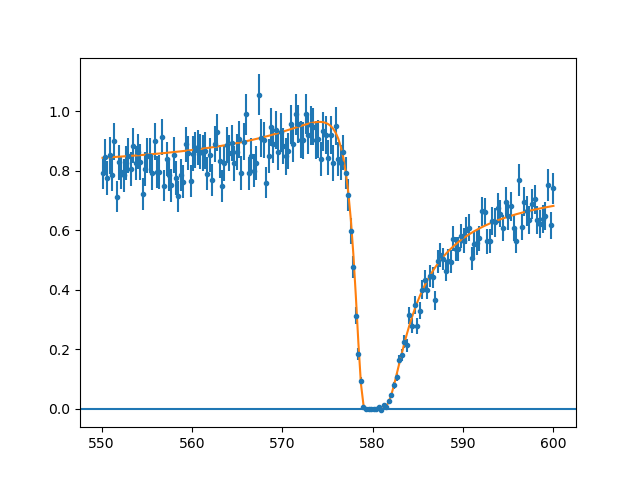

In [14]:
#%%
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


# resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
resonance_ladder = pd.DataFrame({'E':[580], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[5000], 'Gg':[75]})
true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)

figure()
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, fmt='.')
plot(exp.theo.E, exp.theo.theo_trans)
axhline(0)

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-5.0, 85.70501045893923)

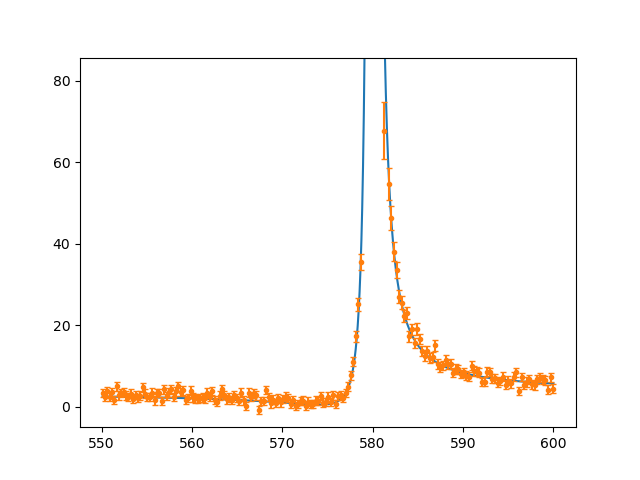

In [15]:
from ATARI.utils.datacontainer import DataContainer
from ATARI.theory.experimental import trans_2_xs

dc = DataContainer()
dc.add_theoretical(Ta_pair, resonance_ladder)
threshold_0T = 1e-2
dc.add_experimental(exp, threshold=threshold_0T)

max_xs, _ = trans_2_xs(threshold_0T, dc.n)

figure()
plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
ylim([-5, max_xs*1.25])

# print(dc.theo_resonance_ladder)

In [16]:

average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5

Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e-2)
# Elam_features, Gtot_features = [565, 569, 570, 571, 575], [0.05, 0.49, 0.50, 0.55]
# print(Elam_features, Gtot_features)
# Gtot_features = [0.490, 0.498, 0.505]
print(len(Elam_features)*len(Gtot_features))

Resonance_Matrix, potential_scattering = fn.get_resonance_feature_bank(dc.pw_exp.E, dc.particle_pair, Elam_features, Gtot_features)
nfeatures = np.shape(Resonance_Matrix)[1]


1503


In [17]:

# do something with nan values in xs
b = np.array(dc.pw_exp.exp_xs)
index_0T = np.argwhere(np.array(np.isnan(dc.pw_exp.exp_xs))).flatten()
b[index_0T] = max_xs 

# setup
b = (b-potential_scattering).flatten()
A = Resonance_Matrix

# get bounds
lb, ub = fn.get_bound_arrays(nfeatures, 0, 1)
G, h = fn.get_0Trans_constraint(A, max_xs, index_0T, dc.pw_exp.E)

# Cast into linear least squares
Lxs = np.linalg.cholesky(inv(dc.CovXS))
bp = Lxs.T @ b
Ap = Lxs.T @ A

# Cast into quadratic program 
P = A.T @ inv(dc.CovXS) @ A
q = - A.T @ inv(dc.CovXS) @ b


# solve least squares
ls_res = lsq_linear(Ap, bp, bounds=(lb,ub), 
                            lsmr_tol='auto', 
                            lsq_solver='lsmr',
                            max_iter = 100, 
                            verbose=1)

# solve linear program
lp_res = linprog(q, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)

# solve quadratic program
qp_res = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
                                                            solver="cvxopt",
                                                            verbose=False,
                                                            abstol=1e-10,
                                                            reltol=1e-10,
                                                            feastol= 1e-8,
                                                            maxiters = 100)



The maximum number of iterations is exceeded.
Number of iterations 100, initial cost 2.5374e+06, final cost 3.3941e+01, first-order optimality 5.47e+00.


(-5.0, 102.84601255072708)

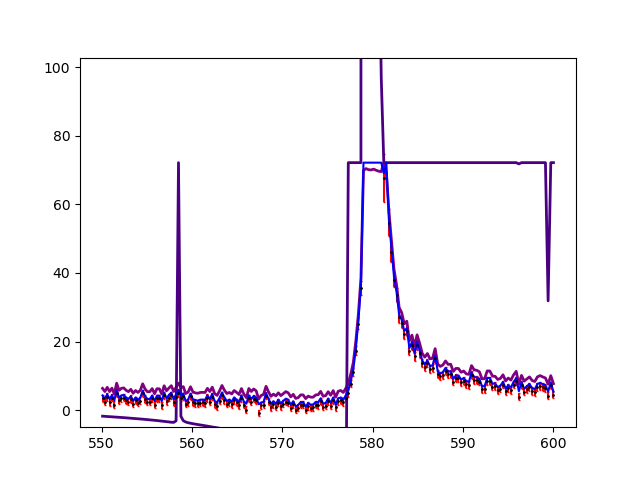

In [18]:
figure()
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
plot(dc.pw_exp.E, Resonance_Matrix@ls_res.x+potential_scattering.flatten(), lw=2, color='purple')
plot(dc.pw_exp.E, Resonance_Matrix@lp_res.x+potential_scattering.flatten(), lw=2, color='indigo')
plot(dc.pw_exp.E, Resonance_Matrix@qp_res+potential_scattering.flatten(), color='blue')

# plot(dc.pw_exp.E, Resonance_Matrix@qp_res)
# plot(dc.pw_exp.E, b, '.')

ylim([-5, max_xs*1.5])

In [22]:
x_constrained = []
lp_constrained = []

for fac in [0.2]: #np.linspace(0,1,50):
    G_wc = np.vstack([G,np.ones(len(qp_res))])
    h_wc = np.append(h, sum(qp_res)*fac)

    # qp_x_c = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, solver="cvxopt")
    lp_res_c = linprog(q, A_ub=G_wc, b_ub=h_wc, bounds=np.array([lb, ub]).T)

    qp_res_c = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt",
                                                        verbose=False) #
                                                        # abstol=1e-10,
                                                        # reltol=1e-10,
                                                        # feastol= 1e-8,
                                                        # maxiters = 500)
    if qp_res_c is None:
        qp_res_c = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt")#,
                                                        # verbose=False,
                                                        # abstol=1e-9,
                                                        # reltol=1e-9,
                                                        # feastol= 1e-7,
                                                        # maxiters = 500)
        
    
    # lp_constrained.append(lp_res.x)
    # x_constrained.append(qp_x_c)


# ws_vs_factor = np.array(x_constrained)
# ws_vs_factor_lp = np.array(lp_constrained)

# np.save(f'wvfactor_{case}.npy',ws_vs_factor)
# np.save(f'wvfactor_{case}_lp.npy',ws_vs_factor_lp)
# np.save( 'factors.npy',factors)

(-5.0, 85.70501045893923)

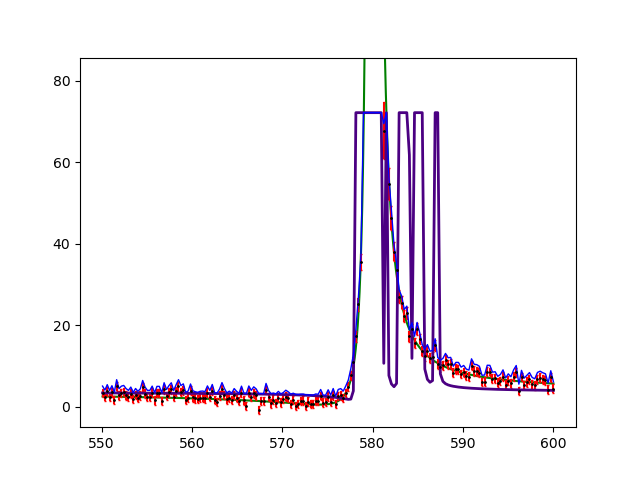

In [23]:

figure()
plot(dc.pw_fine.E, dc.pw_fine.theo_xs, 'g')
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(dc.pw_exp.E, Resonance_Matrix@ls_res.x+potential_scattering.flatten(), lw=2, color='purple')
plot(dc.pw_exp.E, Resonance_Matrix@lp_res_c.x+potential_scattering.flatten(), lw=2, color='indigo')
plot(dc.pw_exp.E, Resonance_Matrix@qp_res_c+potential_scattering.flatten(), lw=1, color='blue')

ylim([-5, max_xs*1.25])

In [12]:
from scipy.integrate import trapezoid
from ATARI.utils.misc import fine_egrid


def calculate_integral_FoMs(weights, Elam_features, Gtot_features, threshold, datacon):
    est_resonance_ladder = fn.get_resonance_ladder_from_feature_bank(weights, Elam_features, Gtot_features, threshold)
    est_resonance_ladder = fill_resonance_ladder(est_resonance_ladder, Ta_pair, J=3.0, chs=1.0, lwave=0.0, J_ID=1.0)

    xs = Resonance_Matrix@weights+potential_scattering.flatten()
    trans = np.exp(-exp.redpar.val.n*xs)

    fineE = fine_egrid(datacon.pw_exp.E, 1e2)
    est_xs_tot, _, _ = SLBW(fineE, datacon.particle_pair, est_resonance_ladder)
    theo_xs_tot, _, _ = SLBW(fineE, datacon.particle_pair, datacon.theo_resonance_ladder)
    MSE = trapezoid((est_xs_tot-theo_xs_tot)**2, fineE)
    bias = est_xs_tot-theo_xs_tot

    return MSE, bias